#Date: 9 aban
#Discription:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential , Model
from keras.applications.vgg16 import VGG16 
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D,MaxPooling2D, Activation, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, Concatenate
from keras.layers import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import os
import glob
import cv2
%matplotlib inline 


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load Data

In [3]:
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base11.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df1 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base12.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df2 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base13.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df3 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base14.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df4 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base21.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df5 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base22.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df6 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base23.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df7 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base24.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df8 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base31.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df9 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base32.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df10 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base33.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); df11 = df.iloc[:][['filename', 'grade']]
df=pd.read_csv('/content/drive/MyDrive/base csv files/Annotation_Base34.csv', names=['filename', 'department', 'grade', 'risk']); df=df.iloc[1:][:].reset_index(); testdf = df.iloc[:][['filename', 'grade']]

In [4]:
traindf = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], axis=0).reset_index(drop=True)
display(traindf)

,filename,grade
0,20051019_38557_0100_PP.tif,3
1,20051020_43808_0100_PP.tif,0
2,20051020_43832_0100_PP.tif,1
3,20051020_43882_0100_PP.tif,2
4,20051020_43906_0100_PP.tif,3
...,...,...
1095,20051205_35305_0400_PP.tif,3
1096,20051205_35323_0400_PP.tif,3
1097,20051205_35339_0400_PP.tif,3
1098,20051205_35354_0400_PP.tif,3


### fix the wrong gradings in dataset which are pointed in (https://www.adcis.net/en/third-party/messidor/)

In [5]:
len(traindf.filename.unique())

1100

In [6]:
traindf.iloc[66][1]='3'
traindf.iloc[65][1]='1'
traindf.iloc[266][1]='3'

## Balancing distrubution in dataset

(array([235.,   0.,   0., 495.,   0.,   0., 145.,   0.,   0., 225.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

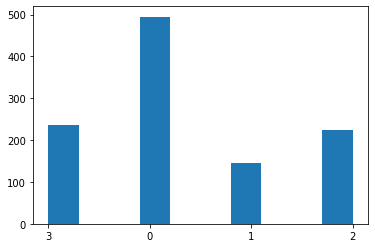

In [7]:
# plot histogram of grades in before balancing
plt.hist(traindf['grade'])

(array([300.,   0.,   0., 300.,   0.,   0., 300.,   0.,   0., 300.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

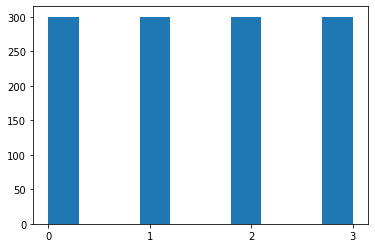

In [8]:
# Balancing using sampling
train_df = traindf.groupby(['grade']).apply(lambda x: x.sample(300, replace = True)).reset_index(drop = True)
plt.hist(train_df['grade'])

## Data augmentation & create datasets

In [9]:
# config (will be used in creating datasets)
tar_width, tar_height = int(528/2), int(790//2) # target shape of images(before crop)
PATH_train = "/content/drive/MyDrive/messidor_images_train/"
PATH_test = "/content/drive/MyDrive/Base34/"
bs = 32

In [10]:
# Create data generator
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    featurewise_center=False,
    featurewise_std_normalization=False,
    #rotation_range=90,
    #brightness_range=[]
    #width_shift_range=0.2,
    #shear_range=0.0,
    #height_shift_range=0.2,
    horizontal_flip=True,
    #vertical_flip=True
    #preprocessing_function = preprocess_input
    )

test_datagen=ImageDataGenerator(rescale=1./255.)

In [11]:
# Define a function to crop the images (removing black background)
def crop_generator(batches, new_size):
    while True:
        batch_x, batch_y = next(batches)
        x= batch_x.shape[1] // 2
        y= batch_x.shape[2] // 2
        size = new_size // 2
        yield ((((batch_x[:, x-size:x+size, y-size:y+size])*255)**1.125)/255, batch_y)

In [12]:
# Train generator
train_generator=crop_generator(train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=PATH_train,
x_col="filename",
y_col="grade",
subset="training",
batch_size=bs,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(tar_width, tar_height)), new_size= 224)

# Validation generator
valid_generator=crop_generator(train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=PATH_train,
x_col="filename",
y_col="grade",
subset="validation",
batch_size=bs,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(tar_width, tar_height)), new_size= 224)

# Test generator
test_generator=crop_generator(test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=PATH_test,
x_col="filename",
y_col="grade",
batch_size=bs,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(tar_width, tar_height)), new_size=224)

Found 825 validated image filenames belonging to 4 classes.
Found 275 validated image filenames belonging to 4 classes.
Found 100 validated image filenames belonging to 4 classes.


## plot augmented data

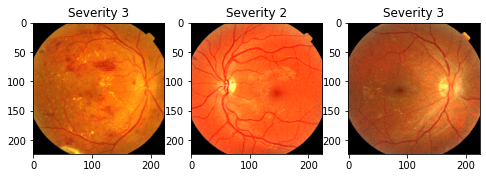

In [13]:
t_x, t_y = next(valid_generator)
fig, m_axs = plt.subplots(1, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*255, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))

## show effect of intensity transfomation

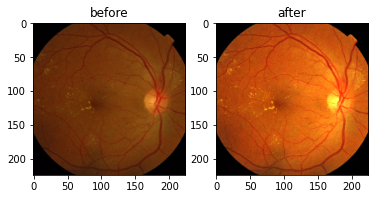

In [28]:
plt.subplot(1,2,1)
plt.imshow(np.clip((c_x*255)**(1/1.125), 0, 255).astype(np.uint8))
plt.title('before')

plt.subplot(1,2,2)
plt.imshow(np.clip(c_x*255, 0, 255).astype(np.uint8))
plt.title('after')
plt.show()

In [14]:
c_x[:,:,:].shape

(224, 224, 3)

# Create Model

### **Vgg16("E" variant) + Attention mechanism 1**
#### I implemented it according to this paper:
https://arxiv.org/pdf/1804.02391.pdf

https://towardsdatascience.com/learn-to-pay-attention-trainable-visual-attention-in-cnns-87e2869f89f1


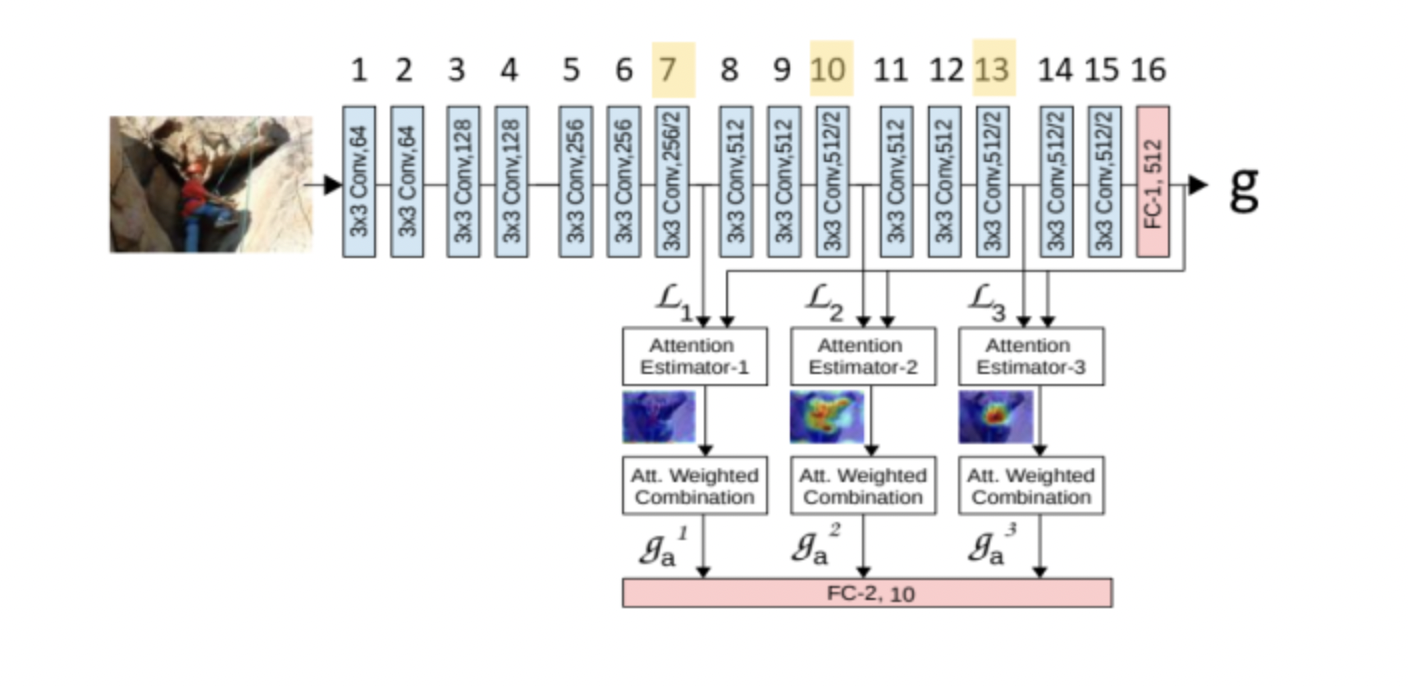

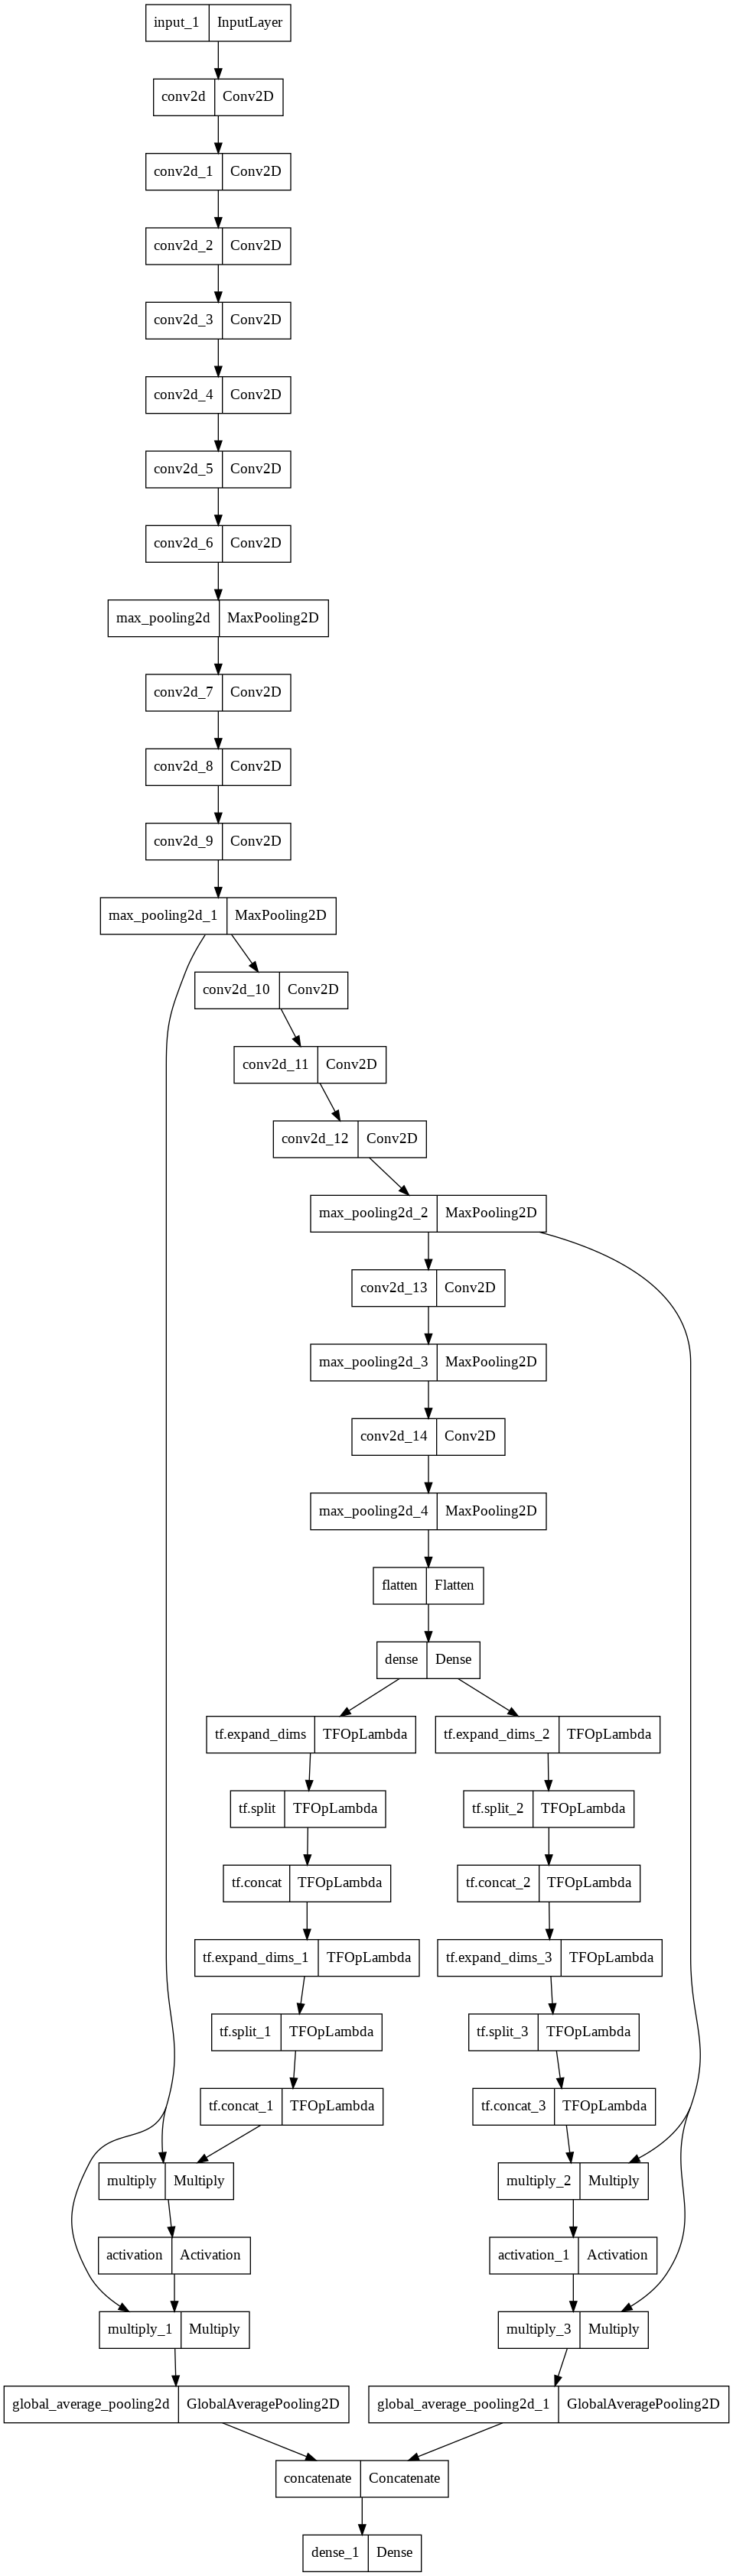

In [15]:
# input  
input = tfkl.Input(shape =(224,224,3))

# 1st Conv Block
x = tfkl.Conv2D(filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = tfkl.Conv2D(filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# according to paper it doesn't have MaxPooling in 1st and 2nd blocks
#x = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x) 

# 2nd Conv Block
x = tfkl.Conv2D(filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = tfkl.Conv2D(filters =128, kernel_size =3, padding ='same', activation='relu')(x)
#x = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 3rd Conv block  
x = tfkl.Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = tfkl.Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = tfkl.Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 4th Conv block
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
c4 = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(c4)
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
c5 = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 6th Conv block
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(c5)
x = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = tfkl.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = tfkl.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers  
x = tfkl.Flatten()(x)
x = tfkl.Dense(units = 512, activation ='relu')(x) 

# Repeat g in (None, 56, 56, 512), because we want to multiply it to output of conv_block4
g = K.expand_dims(x,axis=1)
g = K.repeat_elements(g, 56, axis=1)
g = K.expand_dims(g,axis=1)
g = K.repeat_elements(g, 56, axis=1)

c = multiply([g, c4])
a = Activation('softmax')(c)
ga = multiply([a, c4])
ga1 = GlobalAveragePooling2D()(ga)

# Repeat g in (None, 28, 28, 512), because we want to multiply it to output of conv_block5
g = K.expand_dims(x,axis=1)
g = K.repeat_elements(g, 28, axis=1)
g = K.expand_dims(g,axis=1)
g = K.repeat_elements(g, 28, axis=1)

c = multiply([g, c5])
a = Activation('softmax')(c)
ga = multiply([a, c5])
ga2 = GlobalAveragePooling2D()(ga)

# Concatenate ga1, ga2
concat_layer = Concatenate()([ga1, ga2])
out = Dense(units = 4, activation ='softmax')(concat_layer)
retina_model = tfk.Model(inputs=input, outputs =out)

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate= 0.001),
                       loss = 'categorical_crossentropy', metrics = ['categorical_accuracy', top_2_accuracy])
tf.keras.utils.plot_model(retina_model)

### ResNet50V2 + Attention mechanism used in Kaggkle Competition

In [16]:
# accuracy 81
in_lay = Input(shape= (224, 224, 3))
base_pretrained_model = tf.keras.applications.ResNet50V2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
#base_pretrained_model.trainable = True
for layer in base_pretrained_model.layers[:-3]:
  layer.trainable= False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)

# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.5)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

# Compile model
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2 (Functional)        (None, 7, 7, 2048)   23564800    ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 2048)  8192        ['resnet50v2[0][0]']             
 alization)                                                                                       
                           

In [35]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=8) # probably needs to be more patient
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [36]:
history = retina_model.fit(train_generator, 
                           steps_per_epoch = 825//bs,
                           validation_data = valid_generator, 
                           validation_steps = 275//bs,
                              epochs = 20, 
                              callbacks = callbacks_list,
                             workers = 0, 
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.3238 - categorical_accuracy: 0.4162 - top_2_accuracy: 0.6513 
Epoch 1: val_loss improved from inf to 1.15989, saving model to retina_weights.best.hdf5
25/25 [==============================] - 398s 16s/step - loss: 1.3238 - categorical_accuracy: 0.4162 - top_2_accuracy: 0.6513 - val_loss: 1.1599 - val_categorical_accuracy: 0.5309 - val_top_2_accuracy: 0.7572 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.1589 - categorical_accuracy: 0.5170 - top_2_accuracy: 0.7415
Epoch 2: val_loss improved from 1.15989 to 1.08922, saving model to retina_weights.best.hdf5
25/25 [==============================] - 72s 3s/step - loss: 1.1589 - categorical_accuracy: 0.5170 - top_2_accuracy: 0.7415 - val_loss: 1.0892 - val_categorical_accuracy: 0.5802 - val_top_2_accuracy: 0.7778 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 1.0975 - categorical_accuracy: 0.5334 - top_2

### InceptionV3 + attention mechanism **CABNet**
https://ieeexplore.ieee.org/document/9195035

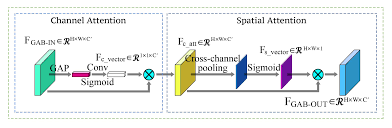

In [17]:
from keras.layers import *

# Global attention block
def Global_attention_block(inputs):
    shape=K.int_shape(inputs)
    x=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('relu') (x)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('sigmoid') (x)
    C_A=Multiply()([x,inputs])
    
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (C_A)
    x=Activation('sigmoid') (x)
    S_A=Multiply()([x,C_A])
    return S_A

# Category attention block
def Category_attention_block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F=Conv2D(k*classes,1, padding='same') (inputs)
    F=BatchNormalization() (F)
    F1=Activation('relu') (F)
    
    F2=F1
    x=GlobalMaxPool2D()(F2)
    
    x=Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    
    x=Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    x=Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (x)
    
    semantic=Multiply()([inputs,M])
    return semantic

# Create model using InceptionV3 and CABNet
k = 5
classes = 4
in_lay = Input(shape=(224, 224, 3))
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3)) 
base_out = base_model(in_lay)
x=Global_attention_block(base_out)
base_out=Category_attention_block(x,classes,k)
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)
retinaa_model = Model(inputs = [in_lay], outputs = [out])
retinaa_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['input_4[0][0]']                
                                                                                                  
 average_pooling2d_9 (AveragePo  (None, 1, 1, 2048)  0           ['inception_v3[0][0]']           
 oling2D)                                                                                         
                           

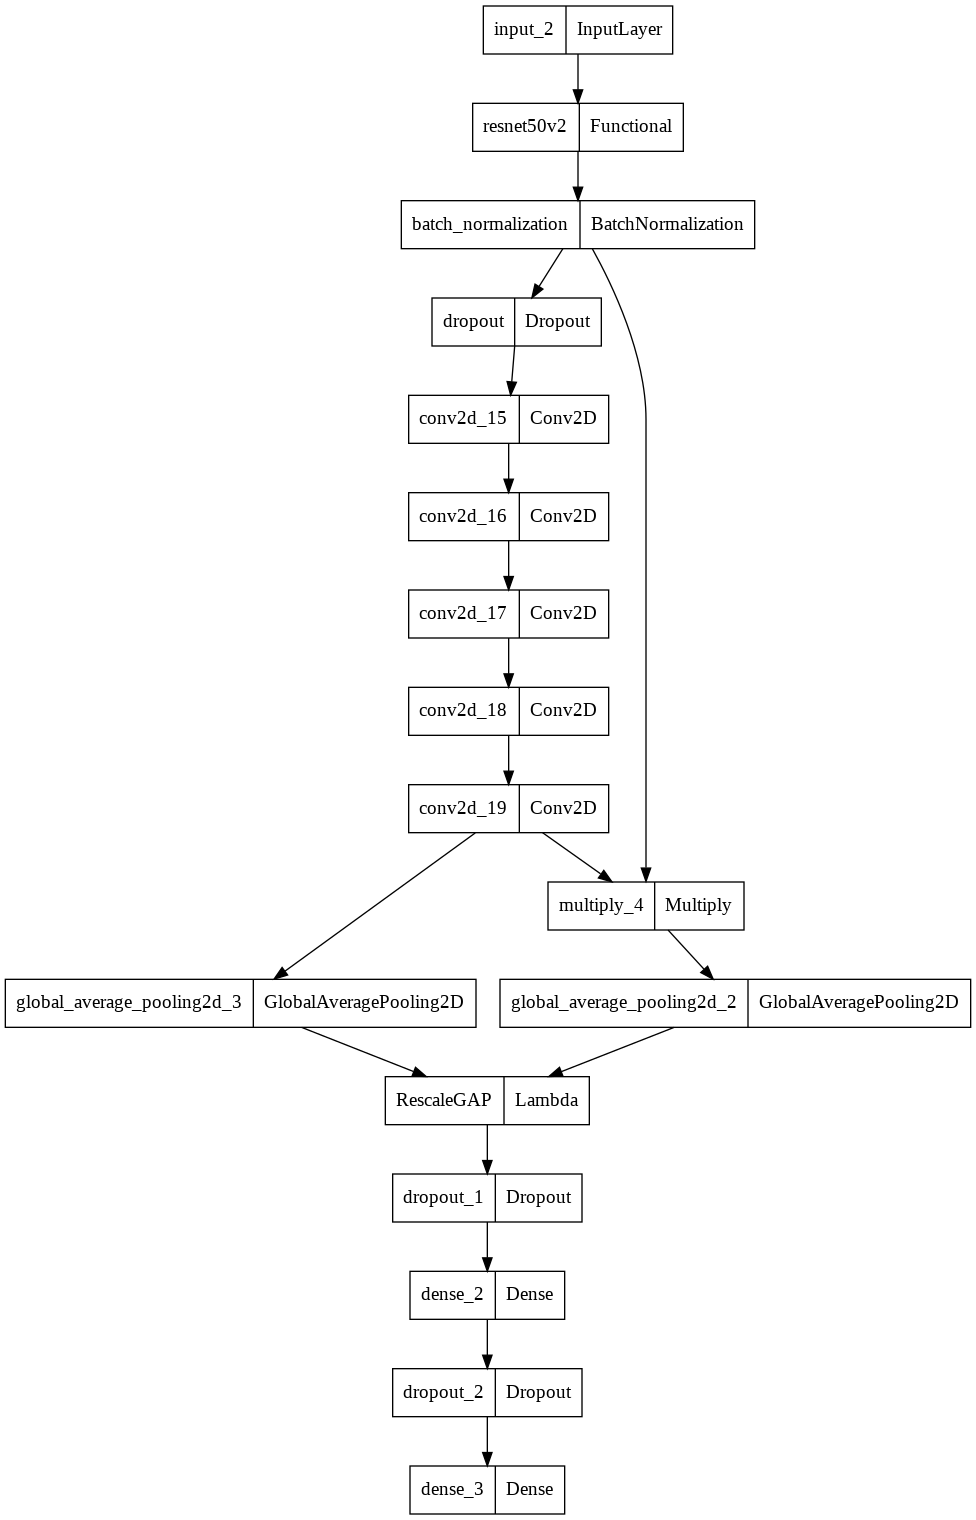

In [24]:
tf.keras.utils.plot_model(retina_model)

## Set Callbacks

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weightss.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

## Compile and Train
one epoch model will be trained with imagenet weights and lr=0.005
then it update weights using lr=0.0001

In [19]:
loss_fun= 'categorical_crossentropy'  
gpu_num=1
lr1=0.005
lr2=0.001
batch_size= 32
image_size=224
train_num , valid_num = 825,275
save_name = 'Inception_messidor_bin'
Epochs1, Epochs2 = 1, 20
lr_decay=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',save_freq=10)

for layer in base_model.layers:
    layer.trainable = False   

retinaa_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
retinaa_model.fit(train_generator,
                    steps_per_epoch=train_num//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_num//batch_size,
                    epochs=Epochs1,
                    workers=0)

for layer in base_model.layers:
    layer.trainable = True

retinaa_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
history = retinaa_model.fit(train_generator,
                    steps_per_epoch=train_num//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_num//16,
                    epochs=Epochs2,
                    workers=0,
                    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/25 [==============================] - 457s 18s/step - loss: 1.3616 - acc: 0.4275 - val_loss: 1.3231 - val_acc: 0.3786
Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.2932 - acc: 0.4729
Epoch 1: val_loss improved from inf to 1293937.50000, saving model to retina_weightss.best.hdf5
25/25 [==============================] - 85s 3s/step - loss: 1.2932 - acc: 0.4729 - val_loss: 1293937.5000 - val_acc: 0.3691 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.2841 - acc: 0.4779
Epoch 2: val_loss improved from 1293937.50000 to 1.37787, saving model to retina_weightss.best.hdf5
25/25 [==============================] - 67s 3s/step - loss: 1.2841 - acc: 0.4779 - val_loss: 1.3779 - val_acc: 0.3900 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 1.2293 - acc: 0.4817
Epoch 3: val_loss did not improve from 1.37787
25/25 [==============================] - 68s 3s/step - loss: 1.2293 - acc: 0.4817 - val_loss: 1.381

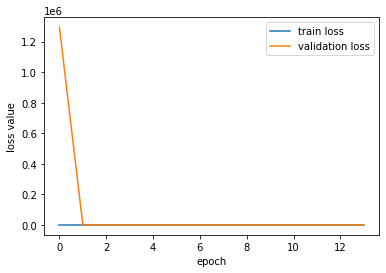

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend(['train loss', 'validation loss'])

In [31]:
retinaa_model.load_weights(weight_path)
retinaa_model.save('full_retina_model.h5')

## get weights and layers output

In [82]:
retina_model.layers[-1].get_weights()[0].shape # 0 for weights, 1 for bias

(128, 4)

In [85]:
retina_model.layers[-2].output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout_2')>

## evaluating

In [25]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
vbatch_count = (275//bs-1)
out_size = vbatch_count*bs
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), valid_generator):
    j = i*bs
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7 [00:00<?, ?it/s]

In [42]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from keras.applications.vgg16 import decode_predictions
import seaborn as sns
tensorflow.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()


## show attention

In [21]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [46]:
attn_layer.get_output_at(0)

<KerasTensor: shape=(None, 14, 14, 1) dtype=float32 (created by layer 'conv2d_97')>

In [59]:
attn_func([cur_img])[0].reshape

(1, 14, 14, 1)

1/1 [==============================] - 0s 24ms/step


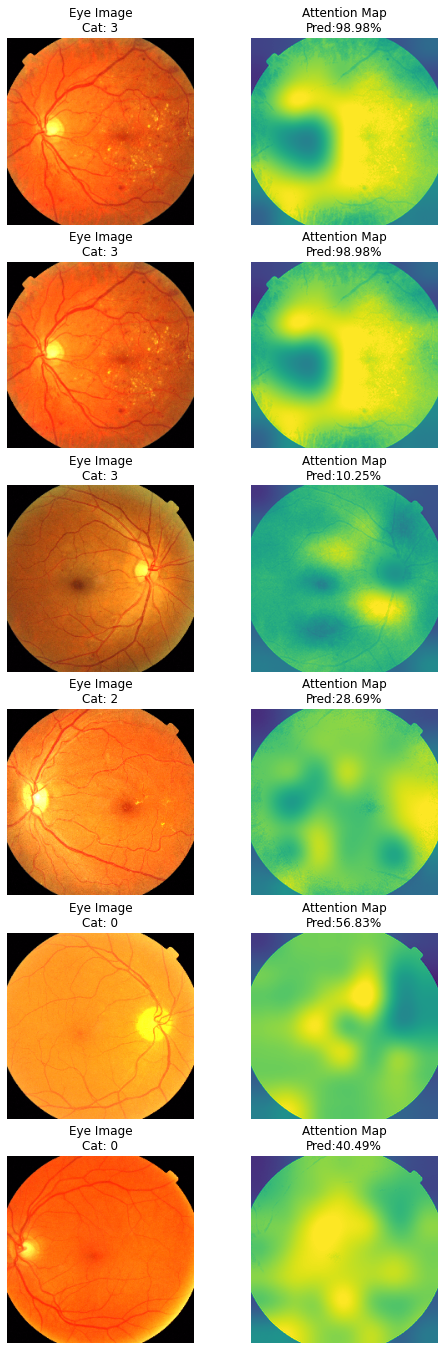

In [24]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
#attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()], outputs = [attn_layer.get_output_at(0)])
attn_func = K.function(inputs = [retina_model.layers[0].output], outputs = [retina_model.layers[-10].output])

fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*255, 0, 255).astype(np.uint8))
    attn_ax.imshow((cv2.resize((attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max())*255, (224,224), interpolation=cv2.INTER_CUBIC) + np.clip(cur_img[0,:,:,0]*255, 0, 255).astype(np.uint8))/2, cmap = 'viridis', 
                   vmin = 0, vmax = 255, 
                   interpolation = 'lanczos')
    #attn_ax.imshow(np.clip(cur_img[0,:,:,:]*255, 0, 255).astype(np.uint8))
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

In [33]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retinaa_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

7/7 [==============================] - 2s 81ms/step
Accuracy on Test Data: 0.50%
              precision    recall  f1-score   support

           0       0.60      0.40      0.48        98
           1       0.00      0.00      0.00        14
           2       0.20      0.41      0.27        34
           3       0.66      0.76      0.70        78

    accuracy                           0.50       224
   macro avg       0.36      0.39      0.36       224
weighted avg       0.52      0.50      0.50       224



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
pr=pred_Y_cat
ts=test_Y_cat

In [35]:
for i in range(len(pr)):
  if pr[i]>0:
    pr[i]=1

for i in range(len(ts)):
  if ts[i]>0:
    ts[i]=1    

In [36]:
accuracy_score(test_Y_cat, pred_Y_cat)

0.6205357142857143

In [37]:
print(classification_report(test_Y_cat, pred_Y_cat))

              precision    recall  f1-score   support

           0       0.60      0.40      0.48        98
           1       0.63      0.79      0.70       126

    accuracy                           0.62       224
   macro avg       0.61      0.60      0.59       224
weighted avg       0.62      0.62      0.60       224



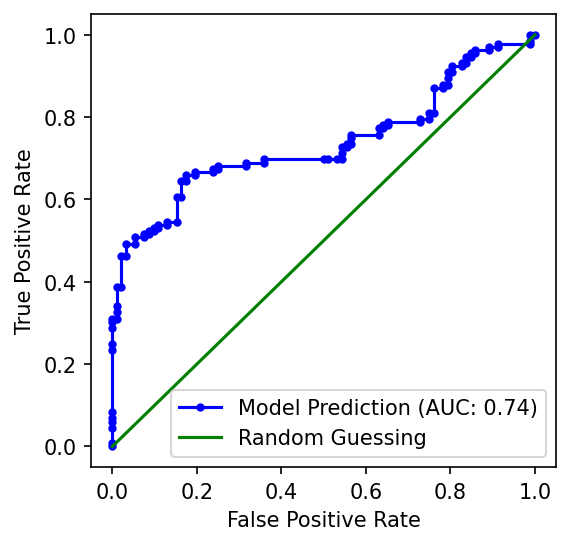

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

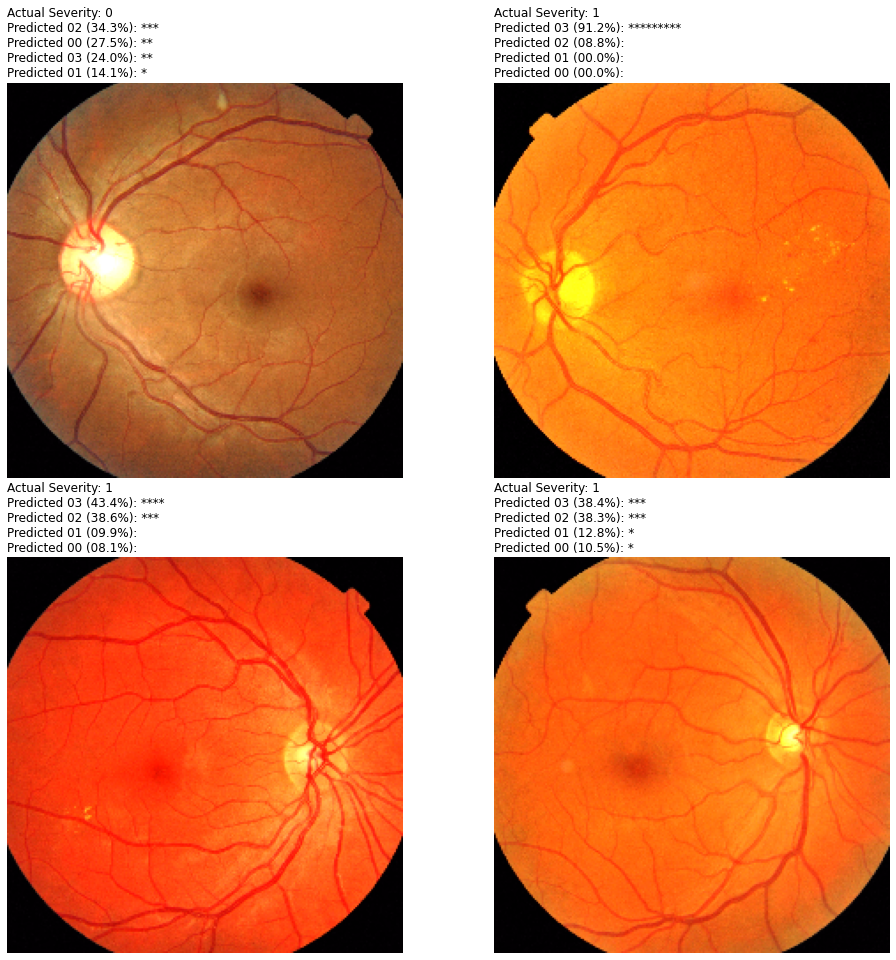

In [41]:
fig, m_axs = plt.subplots(2, 2, figsize = (16, 16))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*255,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)